In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr, entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# load the data and show the head
data = pd.read_csv("RFLFSODataFull.csv")
data.head()
# check the data type and not null data
data.info()
# Display basic statistical details
data.describe()
# The number of each values of frequency feature
data['Frequency'].value_counts()
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int64  
 15  Te

In [16]:
data_by_synop = {
    'data_0': train_data[train_data['SYNOPCode'] == 0],
    'data_3': train_data[train_data['SYNOPCode'] == 3],
    'data_4': train_data[train_data['SYNOPCode'] == 4],
    'data_5': train_data[train_data['SYNOPCode'] == 5],
    'data_6': train_data[train_data['SYNOPCode'] == 6],
    'data_7': train_data[train_data['SYNOPCode'] == 7],
    'data_8': train_data[train_data['SYNOPCode'] == 8]
}

best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity']
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

# save the model and predict
models_fso = {}


# save the model and predict
models_fso = {}
total_y_true_fso = []
total_y_pred_fso = []

for key, data_subset in data_by_synop.items():
    features = best_features_fso[key]
    X_fso = data_subset[features]
    y_fso = data_subset['FSO_Att']

    # change the data to test and train data set
    X_train_fso, X_test_fso, y_train_fso, y_test_fso = train_test_split(
        X_fso, y_fso, test_size=0.3, random_state=42
    )

    rf_fso = RandomForestRegressor(random_state=42)
    grid_search_fso = GridSearchCV(estimator=rf_fso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_fso.fit(X_train_fso, y_train_fso)

    # Get the best model and save it
    best_model_fso = grid_search_fso.best_estimator_
    models_fso[key] = best_model_fso

    # Make predictions on the test set
    y_pred_fso = best_model_fso.predict(X_test_fso)

    # Calculate and print the R² and RMSE for each model
    r2 = r2_score(y_test_fso, y_pred_fso)
    rmse = root_mean_squared_error(y_test_fso, y_pred_fso)  # RMSE

    print(f"Best FSO model for {key}: {grid_search_fso.best_params_}")
    print(f"R² for {key}: {r2:.4f}, RMSE: {rmse:.4f}")

    # The predicted and true values are accumulated into the total result
    total_y_true_fso.extend(y_test_fso)
    total_y_pred_fso.extend(y_pred_fso)

    # Add the prediction back to the data set as a new feature
    data_by_synop[key] = data_by_synop[key].copy()
    data_by_synop[key]['FSO_Pred'] = best_model_fso.predict(X_fso)

# Merge all subsets into one complete data set
updated_data = pd.concat(data_by_synop.values())
# === Calculates the total R² and RMSE ===
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.6701, RMSE: 2.0258
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_3: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.8630, RMSE: 2.9351
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_4: 0.9625, RMSE: 0.7895
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
R² for data_5: 0.8563, RMSE: 1.4001
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.6648, RMSE: 2.5176
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best

In [17]:
# Define the best feature set for the RFL model
best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time', 'FSO_Pred'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'TemperatureMax', 'FSO_Pred'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature', 'FSO_Pred'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax', 'FSO_Pred'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity', 'FSO_Pred'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference', 'FSO_Pred'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin', 'FSO_Pred']
}

# Store models and predictions for the RFL
models_rfl = {}
total_y_true_rfl = []
total_y_pred_rfl = []

# Each subset is traversed for RFL model training and prediction
for key, data_subset in data_by_synop.items():
    features = best_features_rfl[key]
    X_rfl = data_subset[features]
    y_rfl = data_subset['RFL_Att']

    # Split data set
    X_train_rfl, X_test_rfl, y_train_rfl, y_test_rfl = train_test_split(X_rfl, y_rfl, test_size=0.3, random_state=42)

    # Hyperparameter tuning using grid search
    rf_rfl = RandomForestRegressor(random_state=42)
    grid_search_rfl = GridSearchCV(estimator=rf_rfl, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_rfl.fit(X_train_rfl, y_train_rfl)

    # save the best model
    best_model_rfl = grid_search_rfl.best_estimator_
    models_rfl[key] = best_model_rfl

    # Make predictions on the test set
    y_pred_rfl = best_model_rfl.predict(X_test_rfl)

    # Accumulate true and predicted values
    total_y_true_rfl.extend(y_test_rfl)
    total_y_pred_rfl.extend(y_pred_rfl)

    print(f"Best RFL model for {key}: {grid_search_rfl.best_params_}")

# Calculate the overall R² and MSE
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_mse_rfl = mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - Mean Squared Error: {total_mse_rfl:.4f}")



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_3: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_7: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_8: {'max_de

In [18]:
# === 1. Use FSO model for prediction on test set and add FSO_Pred feature ===
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # Use the FSO model to make predictions on the test set and add FSO_Pred features
        fso_pred = fso_model.predict(test_subset[features_fso])
        test_data.loc[test_subset.index, 'FSO_Pred'] = fso_pred

print("FSO model predict finished，FSO_Pred already add as the feature in test data。")

FSO model predict finished，FSO_Pred already add as the feature in test data。


In [19]:
# === 2.Use the RFL model on the test set to make predictions and calculate the performance ===
total_y_true_rfl = []
total_y_pred_rfl = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]  # Contains the FSO_Pred feature

        # Extract the features and labels of the test set
        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        # predict for RFL model
        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # Accumulate true and predicted values
        total_y_true_rfl.extend(y_test_rfl)
        total_y_pred_rfl.extend(y_pred_rfl)

        print(f"RFL predict finished：{key}")

# === 3. Calculate the overall R² and RMSE ===
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_rmse_rfl = root_mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - RMSE: {total_rmse_rfl:.4f}")

RFL predict finished：data_0
RFL predict finished：data_3
RFL predict finished：data_4
RFL predict finished：data_5
RFL predict finished：data_6
RFL predict finished：data_7
RFL predict finished：data_8
Total RFL Model - R2 Score: 0.8744
Total RFL Model - RMSE: 1.2139


In [20]:
# === 2. The FSO and RFL models are used on the test set to make predictions and calculate performance ===
performance_metrics_fso = {}
performance_metrics_rfl = {}

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    # FSO 模型性能计算
    if key in models_fso:  # Check whether a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # predict the FSO model
        y_pred_fso = fso_model.predict(X_test_fso)

        # Calculate the R² and RMSE for each SYNOPCode
        r2_fso = r2_score(y_test_fso, y_pred_fso)
        rmse_fso = root_mean_squared_error(y_test_fso, y_pred_fso)

        # Store the result in a dictionary
        performance_metrics_fso[key] = {'R2': r2_fso, 'RMSE': rmse_fso}

        print(f"FSO 预测完成：{key}")
        print(f"SYNOPCode {key} - FSO R2 Score: {r2_fso:.4f}, RMSE: {rmse_fso:.4f}")

    # RFL model performance calculation
    if key in models_rfl:  # Check whether a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]  # Extract the corresponding best features

        # Extract the features and labels of the test set
        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        # Predictions are made using the RFL model
        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # Calculate the R² and RMSE for each SYNOPCode
        r2_rfl = r2_score(y_test_rfl, y_pred_rfl)
        rmse_rfl = root_mean_squared_error(y_test_rfl, y_pred_rfl)

        # save the result to dictionary
        performance_metrics_rfl[key] = {'R2': r2_rfl, 'RMSE': rmse_rfl}

        print(f"RFL 预测完成：{key}")
        print(f"SYNOPCode {key} - RFL R2 Score: {r2_rfl:.4f}, RMSE: {rmse_rfl:.4f}")

# Print FSO and RFL performance for each SYNOPCode
print("\nPerformance Metrics for FSO by SYNOPCode:")
for synop_code, metrics in performance_metrics_fso.items():
    print(f"SYNOPCode {synop_code} - FSO R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")

print("\nPerformance Metrics for RFL by SYNOPCode:")
for synop_code, metrics in performance_metrics_rfl.items():
    print(f"SYNOPCode {synop_code} - RFL R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")

FSO 预测完成：data_0
SYNOPCode data_0 - FSO R2 Score: 0.6600, RMSE: 2.0187
RFL 预测完成：data_0
SYNOPCode data_0 - RFL R2 Score: 0.9302, RMSE: 0.6727
FSO 预测完成：data_3
SYNOPCode data_3 - FSO R2 Score: 0.9119, RMSE: 2.6143
RFL 预测完成：data_3
SYNOPCode data_3 - RFL R2 Score: 0.9521, RMSE: 0.6761
FSO 预测完成：data_4
SYNOPCode data_4 - FSO R2 Score: 0.9701, RMSE: 0.6713
RFL 预测完成：data_4
SYNOPCode data_4 - RFL R2 Score: 0.8477, RMSE: 0.6245
FSO 预测完成：data_5
SYNOPCode data_5 - FSO R2 Score: 0.8288, RMSE: 1.4929
RFL 预测完成：data_5
SYNOPCode data_5 - RFL R2 Score: 0.8967, RMSE: 0.9304
FSO 预测完成：data_6
SYNOPCode data_6 - FSO R2 Score: 0.6748, RMSE: 2.4384
RFL 预测完成：data_6
SYNOPCode data_6 - RFL R2 Score: 0.7512, RMSE: 1.9972
FSO 预测完成：data_7
SYNOPCode data_7 - FSO R2 Score: 0.9372, RMSE: 1.4520
RFL 预测完成：data_7
SYNOPCode data_7 - RFL R2 Score: 0.9134, RMSE: 0.4990
FSO 预测完成：data_8
SYNOPCode data_8 - FSO R2 Score: 0.9060, RMSE: 1.1738
RFL 预测完成：data_8
SYNOPCode data_8 - RFL R2 Score: 0.8408, RMSE: 1.2243

Performance Metrics

In [21]:
# Define data sets and optimal feature sets (RFL does not require RF_Pred)
data_by_synop = {
    'data_0': train_data[train_data['SYNOPCode'] == 0],
    'data_3': train_data[train_data['SYNOPCode'] == 3],
    'data_4': train_data[train_data['SYNOPCode'] == 4],
    'data_5': train_data[train_data['SYNOPCode'] == 5],
    'data_6': train_data[train_data['SYNOPCode'] == 6],
    'data_7': train_data[train_data['SYNOPCode'] == 7],
    'data_8': train_data[train_data['SYNOPCode'] == 8]
}

best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'TemperatureMax'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin']
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

# Store models and predictions
models_rfl = {}
total_y_true_rfl = []
total_y_pred_rfl = []

# === RFL model training and prediction ===
for key, data_subset in data_by_synop.items():
    features = best_features_rfl[key]
    X_rfl = data_subset[features]
    y_rfl = data_subset['RFL_Att']

    # Split the data into training sets and test sets
    X_train_rfl, X_test_rfl, y_train_rfl, y_test_rfl = train_test_split(
        X_rfl, y_rfl, test_size=0.3, random_state=42
    )

    # Hyperparameter tuning using grid search
    rf_rfl = RandomForestRegressor(random_state=42)
    grid_search_rfl = GridSearchCV(estimator=rf_rfl, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_rfl.fit(X_train_rfl, y_train_rfl)

    # Get the best model and save it
    best_model_rfl = grid_search_rfl.best_estimator_
    models_rfl[key] = best_model_rfl

    # Make predictions on the test set
    y_pred_rfl = best_model_rfl.predict(X_test_rfl)

    # Calculate and print the R² and RMSE for each model
    r2 = r2_score(y_test_rfl, y_pred_rfl)
    rmse = root_mean_squared_error(y_test_rfl, y_pred_rfl)  # RMSE

    print(f"Best RFL model for {key}: {grid_search_rfl.best_params_}")
    print(f"R² for {key}: {r2:.4f}, RMSE: {rmse:.4f}")

    # The predicted and true values are accumulated into the total result
    total_y_true_rfl.extend(y_test_rfl)
    total_y_pred_rfl.extend(y_pred_rfl)

    # Add the prediction back to the data set as a new feature
    data_by_synop[key] = data_by_synop[key].copy()
    data_by_synop[key]['RFL_Pred'] = best_model_rfl.predict(X_rfl)

# Merge all subsets into one complete data set for FSO training
updated_data = pd.concat(data_by_synop.values())

# === Calculates the total R² and RMSE ===
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_rmse_rfl = root_mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - RMSE: {total_rmse_rfl:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.9284, RMSE: 0.6833
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_3: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.9630, RMSE: 0.5234
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
R² for data_4: 0.7626, RMSE: 0.9381
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_5: 0.8879, RMSE: 0.9428
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.7392, RMSE: 2.0582
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best R

In [22]:
best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'RFL_Pred'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time', 'RFL_Pred'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time', 'RFL_Pred'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax', 'RFL_Pred'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'RFL_Pred'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin', 'RFL_Pred'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity', 'RFL_Pred']
}

# Store FSO models and predictions
models_fso = {}
total_y_true_fso = []
total_y_pred_fso = []

# === 3. Train the FSO model and save the best model ===
for key, data_subset in data_by_synop.items():
    features = best_features_fso[key]
    X_fso = data_subset[features]
    y_fso = data_subset['FSO_Att']

    # Split the training set and test set
    X_train_fso, X_test_fso, y_train_fso, y_test_fso = train_test_split(X_fso, y_fso, test_size=0.3, random_state=42)

    # Hyperparameter tuning using grid search
    rf_fso = RandomForestRegressor(random_state=42)
    grid_search_fso = GridSearchCV(estimator=rf_fso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_fso.fit(X_train_fso, y_train_fso)

    # save the best model
    best_model_fso = grid_search_fso.best_estimator_
    models_fso[key] = best_model_fso

    # predict on the test set
    y_pred_fso = best_model_fso.predict(X_test_fso)

    # predict on the train set
    total_y_true_fso.extend(y_test_fso)
    total_y_pred_fso.extend(y_pred_fso)

    print(f"Best FSO model for {key}: {grid_search_fso.best_params_}")

# calculate the R² and RMSE
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_3: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_7: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_8: {'max_de

In [23]:
from scipy.stats import pearsonr
import numpy as np

# === 1. Use the RFL model for prediction on the test set and add the RFL_Pred feature === =
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # The RFL model is used to make predictions on the test set and to add RFL_Pred features
        rfl_pred = rfl_model.predict(test_subset[features_rfl])
        test_data.loc[test_subset.index, 'RFL_Pred'] = rfl_pred

print("The RFL model prediction is complete and the RFL_Pred feature has been added to the test data.")
total_y_true_fso = []
total_y_pred_fso = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # The FSO model is used for prediction
        y_pred_fso = fso_model.predict(X_test_fso)

        # Accumulate true and predicted values
        total_y_true_fso.extend(y_test_fso)
        total_y_pred_fso.extend(y_pred_fso)

        print(f"FSO predict complete：{key}")

# === 3. Calculate the overall R² and RMSE ===
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")

The RFL model prediction is complete and the RFL_Pred feature has been added to the test data.
FSO predict complete：data_0
FSO predict complete：data_3
FSO predict complete：data_4
FSO predict complete：data_5
FSO predict complete：data_6
FSO predict complete：data_7
FSO predict complete：data_8
Total FSO Model - R2 Score: 0.8220
Total FSO Model - RMSE: 1.6321


In [24]:
# === 2. Use FSO and RFL models on the test set to make predictions and calculate performance ===
performance_metrics_fso = {}
performance_metrics_rfl = {}

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    # FSO model performance calculation
    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # The FSO model is used for prediction
        y_pred_fso = fso_model.predict(X_test_fso)

        # Calculate the R² and RMSE for each SYNOPCode
        r2_fso = r2_score(y_test_fso, y_pred_fso)
        rmse_fso = root_mean_squared_error(y_test_fso, y_pred_fso)

        # save the result to dictionary
        performance_metrics_fso[key] = {'R2': r2_fso, 'RMSE': rmse_fso}

        print(f"FSO 预测完成：{key}")
        print(f"SYNOPCode {key} - FSO R2 Score: {r2_fso:.4f}, RMSE: {rmse_fso:.4f}")

    # RFL model performance calculation
    if key in models_rfl:
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # Extract the features and labels of the test set
        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        # Predictions are made using the RFL model
        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # calculate the R² and RMSE to each SYNOPCode
        r2_rfl = r2_score(y_test_rfl, y_pred_rfl)
        rmse_rfl = root_mean_squared_error(y_test_rfl, y_pred_rfl)

        # save the result to dictionary
        performance_metrics_rfl[key] = {'R2': r2_rfl, 'RMSE': rmse_rfl}

        print(f"RFL 预测完成：{key}")
        print(f"SYNOPCode {key} - RFL R2 Score: {r2_rfl:.4f}, RMSE: {rmse_rfl:.4f}")

# print the FSO and RFL performance for each SYNOPCode
print("\nPerformance Metrics for FSO by SYNOPCode:")
for synop_code, metrics in performance_metrics_fso.items():
    print(f"SYNOPCode {synop_code} - FSO R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")

print("\nPerformance Metrics for RFL by SYNOPCode:")
for synop_code, metrics in performance_metrics_rfl.items():
    print(f"SYNOPCode {synop_code} - RFL R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")


FSO 预测完成：data_0
SYNOPCode data_0 - FSO R2 Score: 0.7767, RMSE: 1.6360
RFL 预测完成：data_0
SYNOPCode data_0 - RFL R2 Score: 0.9222, RMSE: 0.7103
FSO 预测完成：data_3
SYNOPCode data_3 - FSO R2 Score: 0.9155, RMSE: 2.5595
RFL 预测完成：data_3
SYNOPCode data_3 - RFL R2 Score: 0.9563, RMSE: 0.6458
FSO 预测完成：data_4
SYNOPCode data_4 - FSO R2 Score: 0.9676, RMSE: 0.6991
RFL 预测完成：data_4
SYNOPCode data_4 - RFL R2 Score: 0.8367, RMSE: 0.6467
FSO 预测完成：data_5
SYNOPCode data_5 - FSO R2 Score: 0.8479, RMSE: 1.4071
RFL 预测完成：data_5
SYNOPCode data_5 - RFL R2 Score: 0.8917, RMSE: 0.9526
FSO 预测完成：data_6
SYNOPCode data_6 - FSO R2 Score: 0.8403, RMSE: 1.7088
RFL 预测完成：data_6
SYNOPCode data_6 - RFL R2 Score: 0.7550, RMSE: 1.9822
FSO 预测完成：data_7
SYNOPCode data_7 - FSO R2 Score: 0.9328, RMSE: 1.5023
RFL 预测完成：data_7
SYNOPCode data_7 - RFL R2 Score: 0.9061, RMSE: 0.5195
FSO 预测完成：data_8
SYNOPCode data_8 - FSO R2 Score: 0.9018, RMSE: 1.1998
RFL 预测完成：data_8
SYNOPCode data_8 - RFL R2 Score: 0.8261, RMSE: 1.2797

Performance Metrics

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

best_features_fso = {
    'data_0': ['Visibility','AbsoluteHumidityMin','TemperatureMax','TemperatureMin','VisibilityMin','Temperature'],
    'data_3': ['VisibilityMax','RelativeHumidity','Distance','Time'],
    'data_4': ['Distance','TemperatureMin','TemperatureDifference','VisibilityMax','ParticulateMin','Time'],
    'data_5': ['VisibilityMax','Temperature','VisibilityMin','ParticulateMax'],
    'data_6': ['Visibility','AbsoluteHumidityMin','TemperatureMax','TemperatureMin','VisibilityMin','Temperature'],
    'data_7': ['Temperature','TemperatureDifference','Particulate','TemperatureMin','ParticulateMin'],
    'data_8': ['Distance','Visibility','AbsoluteHumidityMax','VisibilityMax','RelativeHumidity']
}

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10],
}

models_fso = {}
performance_metrics_fso = {}

for i in [0, 3, 4, 5, 6, 7, 8]:
    data_subset = data_by_synop.get(f'data_{i}')

    if data_subset is not None:
        X_fso = data_subset[best_features_fso[f'data_{i}']]
        y_fso = data_subset['FSO_Att']

        # Split training set and test set
        X_train_fso, X_test_fso, y_train_fso, y_test_fso = train_test_split(
            X_fso, y_fso, test_size=0.3, random_state=42
        )

        # Grid search for hyperparameter tuning
        rf = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train_fso, y_train_fso)

        # Prints the performance of each parameter combination
        print(f"Grid search results for data_{i}:")
        results = pd.DataFrame(grid_search.cv_results_)
        print(results[['param_n_estimators', 'param_max_features', 'param_max_depth', 'mean_test_score']])

        # Get the best model
        best_model_fso = grid_search.best_estimator_
        models_fso[f'data_{i}'] = best_model_fso

        # predicy on test data
        y_pred_fso = best_model_fso.predict(X_test_fso)

        # Calculate and store the performance of each SYNOPCode
        r2 = r2_score(y_test_fso, y_pred_fso)
        mse = mean_squared_error(y_test_fso, y_pred_fso)
        performance_metrics_fso[f'data_{i}'] = {'R2': r2, 'MSE': mse}

        print(f"SYNOPCode data_{i} - R2 Score: {r2:.4f}")
        print(f"SYNOPCode data_{i} - Mean Squared Error: {mse:.4f}")

print("\nPerformance Metrics by SYNOPCode:")
for synop_code, metrics in performance_metrics_fso.items():
    print(f"SYNOPCode {synop_code} - R2 Score: {metrics['R2']:.4f}, MSE: {metrics['MSE']:.4f}")

# Create a function to call the corresponding FSO model based on SYNOPCode to make predictions
def predict_fso(data_row):
    synop_code = data_row['SYNOPCode']
    model_fso = models_fso.get(f'data_{synop_code}')
    if model_fso is not None:
        features_fso = best_features_fso[f'data_{synop_code}']
        fso_pred = model_fso.predict(data_row[features_fso].values.reshape(1, -1))
        return fso_pred
    else:
        raise ValueError(f"No model found for SYNOPCode {synop_code}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Grid search results for data_0:
    param_n_estimators param_max_features  param_max_depth  mean_test_score
0                   50               sqrt                5         0.551937
1                  100               sqrt                5         0.555286
2                  200               sqrt                5         0.555079
3                   50               log2                5         0.551937
4                  100               log2                5         0.555286
5                  200               log2                5         0.555079
6                   50               sqrt                7         0.612775
7                  100               sqrt                7         0.614749
8                  200               sqrt                7         0.614783
9                   50               log2                7         0.612775
10                 100               log2                7         0.61

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

best_features_rfl = {
    'data_0': ['Distance','Frequency', 'TemperatureMax', 'Time'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'Temperature', 'AbsoluteHumidity', 'TemperatureMin', 'AbsoluteHumidityMin', 'TemperatureMax'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin'],
    'data_5': ['Distance','Frequency','AbsoluteHumidityMax','AbsoluteHumidity','ParticulateMax','VisibilityMin','VisibilityMax'],
    'data_6': ['Particulate','Distance','TemperatureMax','VisibilityMin','AbsoluteHumidity','RainIntensity','AbsoluteHumidityMax','RainIntensityMax','Temperature'],
    'data_7': ['Time','RelativeHumidity','RainIntensityMax','RainIntensity','TemperatureDifference','RainIntensityMin'],
    'data_8': ['Distance','AbsoluteHumidityMax','TemperatureDifference','Frequency','RainIntensityMin','RainIntensity','RainIntensityMax','WindSpeed','Temperature']
}

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10],
}

models_rfl = {}
performance_metrics_rfl = {}

for i in [0, 3, 4, 5, 6, 7, 8]:
    data_subset = data_by_synop.get(f'data_{i}')

    if data_subset is not None:
        X_rfl = data_subset[best_features_rfl[f'data_{i}']]
        y_rfl = data_subset['RFL_Att']

        # Split training set and test set
        X_train_rfl, X_test_rfl, y_train_rfl, y_test_rfl = train_test_split(
            X_rfl, y_rfl, test_size=0.3, random_state=42
        )

        # Hyperparameter tuning for grid search
        rf = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train_rfl, y_train_rfl)

        # Prints the performance of each parameter combination
        print(f"Grid search results for data_{i}:")
        results = pd.DataFrame(grid_search.cv_results_)
        print(results[['param_n_estimators', 'param_max_features', 'param_max_depth', 'mean_test_score']])

        # get the best model
        best_model_rfl = grid_search.best_estimator_
        models_rfl[f'data_{i}'] = best_model_rfl

        # predict on test data
        y_pred_rfl = best_model_rfl.predict(X_test_rfl)

        # Calculate and store the performance of each SYNOPCode
        r2 = r2_score(y_test_rfl, y_pred_rfl)
        mse = mean_squared_error(y_test_rfl, y_pred_rfl)
        performance_metrics_rfl[f'data_{i}'] = {'R2': r2, 'MSE': mse}

        print(f"SYNOPCode data_{i} - R2 Score: {r2:.4f}")
        print(f"SYNOPCode data_{i} - Mean Squared Error: {mse:.4f}")

# Prints the performance of each SYNOPCode
print("\nPerformance Metrics by SYNOPCode:")
for synop_code, metrics in performance_metrics_rfl.items():
    print(f"SYNOPCode {synop_code} - R2 Score: {metrics['R2']:.4f}, MSE: {metrics['MSE']:.4f}")

# Create a function to call the corresponding RFL model based on SYNOPCode to make predictions
def predict_rfl(data_row):
    synop_code = data_row['SYNOPCode']
    model_rfl = models_rfl.get(f'data_{synop_code}')
    if model_rfl is not None:
        features_rfl = best_features_rfl[f'data_{synop_code}']
        rfl_pred = model_rfl.predict(data_row[features_rfl].values.reshape(1, -1))
        return rfl_pred
    else:
        raise ValueError(f"No model found for SYNOPCode {synop_code}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Grid search results for data_0:
    param_n_estimators param_max_features  param_max_depth  mean_test_score
0                   50               sqrt                5         0.825847
1                  100               sqrt                5         0.826877
2                  200               sqrt                5         0.829409
3                   50               log2                5         0.825847
4                  100               log2                5         0.826877
5                  200               log2                5         0.829409
6                   50               sqrt                7         0.887870
7                  100               sqrt                7         0.887104
8                  200               sqrt                7         0.887485
9                   50               log2                7         0.887870
10                 100               log2                7         0.88

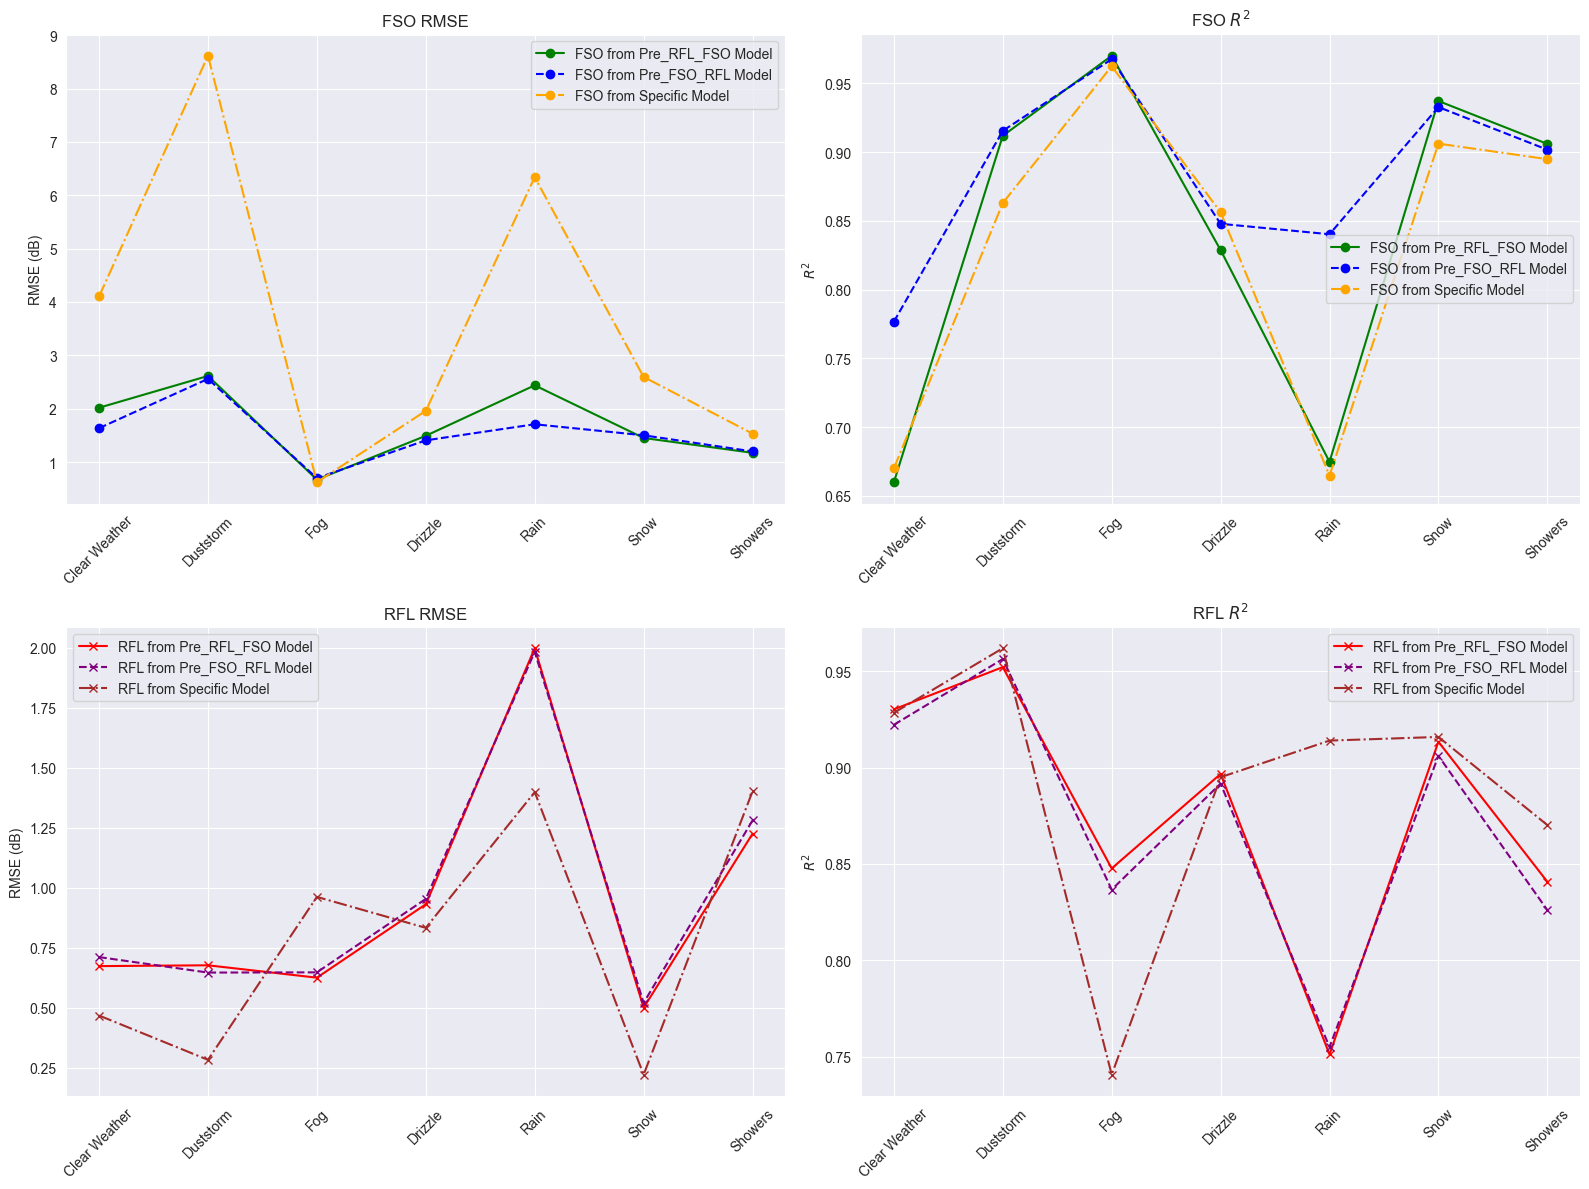

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define the weather conditions for x-axis labels
weather_conditions = ['Clear Weather', 'Duststorm', 'Fog', 'Drizzle', 'Rain', 'Snow', 'Showers']

# RMSE data for each model and weather condition
rmse_model1_fso = [2.0187, 2.6143, 0.6713, 1.4929, 2.4384, 1.4520, 1.1738]
rmse_model2_fso = [1.6360, 2.5595, 0.6991, 1.4071, 1.7088, 1.5023, 1.1998]
rmse_model3_fso = [4.1039, 8.6146, 0.6234, 1.9603, 6.3382, 2.5954, 1.5333]

rmse_model1_rfl = [0.6727, 0.6761, 0.6245, 0.9304, 1.9972, 0.4990, 1.2243]
rmse_model2_rfl = [0.7103, 0.6458, 0.6467, 0.9526, 1.9822, 0.5195, 1.2797]
rmse_model3_rfl = [0.4668, 0.2821, 0.9612, 0.8321, 1.3978, 0.2203, 1.4007]

# R² data for each model and weather condition
r2_model1_fso = [0.6600, 0.9119, 0.9701, 0.8288, 0.6748, 0.9372, 0.9060]
r2_model2_fso = [0.7767, 0.9155, 0.9676, 0.8479, 0.8403, 0.9328, 0.9018]
r2_model3_fso = [0.6701, 0.8630, 0.9625, 0.8563, 0.6648, 0.9062, 0.8949]

r2_model1_rfl = [0.9302, 0.9521, 0.8477, 0.8967, 0.7512, 0.9134, 0.8408]
r2_model2_rfl = [0.9222, 0.9563, 0.8367, 0.8917, 0.7550, 0.9061, 0.8261]
r2_model3_rfl = [0.9284, 0.9619, 0.7407, 0.8950, 0.9140, 0.9159, 0.8702]

# Create the plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot FSO RMSE
axes[0, 0].plot(weather_conditions, rmse_model1_fso, marker='o', label='FSO from Pre_RFL_FSO Model', color='green')
axes[0, 0].plot(weather_conditions, rmse_model2_fso, marker='o', linestyle='--', label='FSO from Pre_FSO_RFL Model', color='blue')
axes[0, 0].plot(weather_conditions, rmse_model3_fso, marker='o', linestyle='-.', label='FSO from Specific Model', color='orange')
axes[0, 0].set_title('FSO RMSE')
axes[0, 0].set_ylabel('RMSE (dB)')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Plot FSO R²
axes[0, 1].plot(weather_conditions, r2_model1_fso, marker='o', label='FSO from Pre_RFL_FSO Model', color='green')
axes[0, 1].plot(weather_conditions, r2_model2_fso, marker='o', linestyle='--', label='FSO from Pre_FSO_RFL Model', color='blue')
axes[0, 1].plot(weather_conditions, r2_model3_fso, marker='o', linestyle='-.', label='FSO from Specific Model', color='orange')
axes[0, 1].set_title('FSO $R^2$')
axes[0, 1].set_ylabel('$R^2$')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot RFL RMSE
axes[1, 0].plot(weather_conditions, rmse_model1_rfl, marker='x', label='RFL from Pre_RFL_FSO Model', color='red')
axes[1, 0].plot(weather_conditions, rmse_model2_rfl, marker='x', linestyle='--', label='RFL from Pre_FSO_RFL Model', color='purple')
axes[1, 0].plot(weather_conditions, rmse_model3_rfl, marker='x', linestyle='-.', label='RFL from Specific Model', color='brown')
axes[1, 0].set_title('RFL RMSE')
axes[1, 0].set_ylabel('RMSE (dB)')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Plot RFL R²
axes[1, 1].plot(weather_conditions, r2_model1_rfl, marker='x', label='RFL from Pre_RFL_FSO Model', color='red')
axes[1, 1].plot(weather_conditions, r2_model2_rfl, marker='x', linestyle='--', label='RFL from Pre_FSO_RFL Model', color='purple')
axes[1, 1].plot(weather_conditions, r2_model3_rfl, marker='x', linestyle='-.', label='RFL from Specific Model', color='brown')
axes[1, 1].set_title('RFL $R^2$')
axes[1, 1].set_ylabel('$R^2$')
axes[1, 1].grid(True)
axes[1, 1].legend()

# Set common x-axis labels
for ax in axes.flat:
    ax.set_xticks(np.arange(len(weather_conditions)))
    ax.set_xticklabels(weather_conditions, rotation=45)

plt.tight_layout()
plt.show()
